In [1]:
import shutil

import pandas as pd
import requests
from gensim.models import KeyedVectors
import json
import numpy as np
import pickle
import os

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as patchesb
import seaborn as sns

from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity

import gspread
from gspread_dataframe import get_as_dataframe, set_with_dataframe
from google.oauth2 import service_account # based on google-auth library

In [37]:
file_data = json.load(open(os.path.expanduser("~/ServiceAccountsKey.json")))
# (2) transform the content into crendentials object
credentials = service_account.Credentials.from_service_account_info(file_data)
# (3) specify your usage of the credentials
scoped_credentials = credentials.with_scopes(
    ['https://spreadsheets.google.com/feeds', 'https://www.googleapis.com/auth/drive'])
# (4) use the constrained credentials for authentication of gspread package
gc = gspread.Client(auth=scoped_credentials)

noscemus_gs = gc.open_by_url(
    "https://docs.google.com/spreadsheets/d/1ekf9RBfd4yqy0p0IWJ4SDk1kUT70hnoIVX1H6KPdIts/edit?usp=sharing")

In [6]:
filtered_vocab_df = pd.read_json("../data/filtered_vocab_df.json")
filtered_vocab_df.head(20)

,word,1501-1550,1551-1600,1601-1650,1651-1700,Medicine,Astronomy/Astrology/Cosmography,Biology,Mathematics,Meteorology/Earth sciences,...,Biology_freq,Mathematics_freq,Meteorology/Earth sciences_freq,Physics_freq,Geography/Cartography_freq,Alchemy/Chemistry_freq,EMLAP_freq,mean_freq,shared,transl
2913,dico,43255,122549,42457,72224,107036,81298,76957,52414,44323,...,0.003069,0.002645,0.002988,0.002912,0.002816,0.002063,0.004034,0.002921,True,"say, call, tell"
2835,liber,39559,65900,38496,53100,97802,65756,65230,49280,50603,...,0.002602,0.002487,0.003411,0.003108,0.003290,0.004743,0.001314,0.002680,True,"book, volume, inner bark of a tree, book, book"
6447,possum,25029,82700,38391,76841,81305,74924,50255,50826,41844,...,0.002004,0.002565,0.002821,0.003553,0.001975,0.002350,0.004110,0.002563,True,"be able, can"
7784,facio,31814,98524,36944,51438,96530,62963,42272,45704,32760,...,0.001686,0.002307,0.002209,0.002487,0.001690,0.001891,0.004597,0.002367,True,"do, make, handle"
5339,habeo,31690,89199,39443,59770,81643,63141,61273,48571,33185,...,0.002444,0.002451,0.002237,0.002355,0.002320,0.001734,0.002807,0.002310,True,"have, hold, possess, consider, think"
5187,pars,33225,93059,44337,52385,95410,65986,42118,53361,31827,...,0.001680,0.002693,0.002146,0.002476,0.001962,0.001895,0.002397,0.002279,True,part
220,res,29069,70669,28291,51565,74400,62681,42267,36572,40633,...,0.001686,0.001846,0.002739,0.002701,0.002085,0.002239,0.002556,0.002129,True,suddenly
5932,uideo,21536,59099,26372,50503,61322,53447,47212,28471,28146,...,0.001883,0.001437,0.001897,0.002244,0.001466,0.001554,0.001730,0.001717,True,
2804,locus,23102,56782,31421,43680,50814,57201,40768,31263,25466,...,0.001626,0.001578,0.001717,0.001703,0.002230,0.001240,0.001090,0.001632,True,"place, location"
3911,aqua,11747,41231,20765,34038,42778,18714,30884,14948,28253,...,0.001232,0.000754,0.001905,0.001437,0.001160,0.001966,0.005758,0.001575,True,"get/fetch/bring water, be watered"


In [3]:
len(filtered_vocab_df)

8118

In [7]:
with open("../data/vectors_dict_comp.pkl", "rb") as file:
    vectors_dict = pickle.load(file)

In [8]:
vectors_dict.keys()

dict_keys(['NOSCEMUS - 1501-1550', 'NOSCEMUS - 1551-1600', 'NOSCEMUS - 1601-1650', 'NOSCEMUS - 1651-1700', 'NOSCEMUS - Alchemy/Chemistry', 'NOSCEMUS - Astronomy/Astrology/Cosmography', 'NOSCEMUS - Biology', 'NOSCEMUS - Geography/Cartography', 'NOSCEMUS - Mathematics', 'NOSCEMUS - Medicine', 'NOSCEMUS - Meteorology/Earth sciences', 'NOSCEMUS - Physics', 'EMLAP', 'LASLA', 'Opera Maiora'])

In [9]:
# get a dictionary object word_transl_dict from columns "word" and "transl"
word_transl_dict = dict(zip(filtered_vocab_df["word"], filtered_vocab_df["transl"]))

In [10]:
def nn_tups_to_transl(nn_tups, shorten_transl=True):
    transl_list = []
    for tup in nn_tups:
        transl = word_transl_dict.get(tup[0], "")
        if shorten_transl:
            if len(transl) >= 10:
                transl = transl[:10] + "..."
        transl_list.append(tup[0] + " ({})".format(transl))
    #transl_list = [tup[0] + " ({})".format(word_transl_dict[tup[0]]) for tup in nn_tups]
    transl_list = [e.replace(" ()", "") for e in transl_list]
    return transl_list

In [15]:
nn_tups_to_transl(vectors_dict["EMLAP"].most_similar("mercurius"), shorten_transl=True)

['sulphur (brimstone,...)',
 'uiuum',
 'argentum (silver, mo...)',
 'uiuus',
 'luna (moon)',
 'congelo (cause to f...)',
 'saturnus',
 'mineralis (mineral-, ...)',
 'metallum (metal, min...)',
 'proiicio']

In [16]:
vectors_dict["LASLA"].similarity("equus", "equa")

0.6677204

In [17]:
vectors_dict["LASLA"].similarity("geometria", "scientia")

0.5682637

In [18]:
vectors_dict["Opera Maiora"].similarity("geometria", "scientia")

0.5577459

In [19]:
vectors_dict["NOSCEMUS - 1501-1550"].similarity("geometria", "scientia")

0.5770002

In [20]:
vectors_dict["NOSCEMUS - 1651-1700"].similarity("geometria", "scientia")

0.72763765

In [21]:
np.mean([tup[1] for tup in vectors_dict["LASLA"].most_similar("scientia")])

0.7608603715896607

In [22]:
def get_weighted_similarity(target1, target2):
    weighted_sims = []
    for key in vectors_dict.keys():
        # calculate average similarity value of ten most similar vectors for both target terms
        nn_avr = np.mean([tup[1] for tup in vectors_dict[key].most_similar(target1, topn=1)] + [tup[1] for tup in vectors_dict[key].most_similar(target2, topn=1)])
        # calculate ordinary similarity between the two terms:
        similarity = vectors_dict[key].similarity("scientia", "geometria")
        # caluculate weighted similarity of the two term
        weighted_sim = similarity / nn_avr
        weighted_sims.append({
            "key" : key,
            "weighted_sim" : weighted_sim
        })
    weighted_sims_df = pd.DataFrame(weighted_sims)
    return weighted_sims_df

In [23]:
targets = ["scientia", "geometria"]
weighted_sims_df = get_weighted_similarity(targets[0], targets[1])
weighted_sims_df

,key,weighted_sim
0,NOSCEMUS - 1501-1550,0.774633
1,NOSCEMUS - 1551-1600,0.860501
2,NOSCEMUS - 1601-1650,0.779546
3,NOSCEMUS - 1651-1700,0.896943
4,NOSCEMUS - Alchemy/Chemistry,0.635014
5,NOSCEMUS - Astronomy/Astrology/Cosmography,0.824340
6,NOSCEMUS - Biology,0.786301
7,NOSCEMUS - Geography/Cartography,0.856072
8,NOSCEMUS - Mathematics,0.902167
9,NOSCEMUS - Medicine,0.816080


In [24]:
def get_table_of_nns(target, topn=20, to_csv=False):
    most_similar_by_per = {}
    for key in vectors_dict.keys():
        try:
            nns = [tup[0] for tup in vectors_dict[key].most_similar(target, topn=topn)]
        except:
            nns = [None] * topn
        most_similar_by_per[key] = nns
    most_similar_df = pd.DataFrame(most_similar_by_per)
    if to_csv:
        filename = target + "_nns.csv"
        most_similar_df.to_csv(filename, index=False)
    return most_similar_df

In [25]:
target = "substantia"
get_table_of_nns(target)

,NOSCEMUS - 1501-1550,NOSCEMUS - 1551-1600,NOSCEMUS - 1601-1650,NOSCEMUS - 1651-1700,NOSCEMUS - Alchemy/Chemistry,NOSCEMUS - Astronomy/Astrology/Cosmography,NOSCEMUS - Biology,NOSCEMUS - Geography/Cartography,NOSCEMUS - Mathematics,NOSCEMUS - Medicine,NOSCEMUS - Meteorology/Earth sciences,NOSCEMUS - Physics,EMLAP,LASLA,Opera Maiora
0,substan,essentia,substan,materia,substan,essentia,materia,substan,substantialis,essentia,materia,materia,natura,distantia,substantifico
1,substantialis,materia,corporeus,substan,substantialis,substantialis,essentia,substantialis,essentia,substan,corporeus,essentia,substantialis,praestantia,substantiuo
2,essentia,natura,substantialis,concretus,materia,substan,substantialis,materia,substan,substantialis,essentia,insum,temperatio,iactantia,substantialis
3,corpus,corpus,materia,corporeus,natura,corporeus,aqueus,essentia,corporeus,materia,corpus,substan,qualitas,constantia,supersubstantialis
4,cerebrum,existo,corpus,substantialis,corpus,materia,necesse,massa,materia,natura,res,ens,materia,inconstantia,subsisto
5,materia,res,essentia,essentia,diuisibilis,corpus,substan,aqueus,corpus,insum,natura,substantialis,essentialis,obseruantia,corpus
6,subtilis,substantialis,natura,corpus,discrepo,ens,natura,humidus,qualitas,qualitas,substantialis,natura,fumosus,excellentia,separo
7,tunica,dico,elementum,corpusculum,aqueus,separo,elementum,dissolutio,insum,corpus,insum,corporeus,elementum,sycophantia,transubstantio
8,praedicamentum,necesse,alimentum,natura,subtilis,subiectum,facultas,corporeus,ens,existo,forma,corpus,dissimilitudo,raritas,materia
9,natura,substan,ens,insum,separo,essentialis,forma,succus,ignis,tia,substan,qualitas,proprietas,differentia,dimensio


In [84]:
#set_with_dataframe(noscemus_gs.add_worksheet("nns_equus_v1", 1,1), nns_equus)

In [ ]:
#set_with_dataframe(noscemus_gs.add_worksheet("nns_seminarium_v1", 1,1), nns_seminarium)

In [26]:
target = "scientia"
topn=10
most_similar_by_per = {}
for subcorpus in vectors_dict.keys():
    nns= nn_tups_to_transl(vectors_dict[subcorpus].most_similar(target, topn=topn), shorten_transl=False)
    most_similar_by_per[subcorpus] = nns
nns_fecundus = pd.DataFrame(most_similar_by_per)
nns_fecundus

,NOSCEMUS - 1501-1550,NOSCEMUS - 1551-1600,NOSCEMUS - 1601-1650,NOSCEMUS - 1651-1700,NOSCEMUS - Alchemy/Chemistry,NOSCEMUS - Astronomy/Astrology/Cosmography,NOSCEMUS - Biology,NOSCEMUS - Geography/Cartography,NOSCEMUS - Mathematics,NOSCEMUS - Medicine,NOSCEMUS - Meteorology/Earth sciences,NOSCEMUS - Physics,EMLAP,LASLA,Opera Maiora
0,"cognitio (examination, inquiry/investigation (...","mathematica (mathematical, astrological)","cognitio (examination, inquiry/investigation (...","cognitio (examination, inquiry/investigation (...",philosophia (philosophy),"cognitio (examination, inquiry/investigation (...","cognitio (examination, inquiry/investigation (...","cognitio (examination, inquiry/investigation (...","cognitio (examination, inquiry/investigation (...","cognitio (examination, inquiry/investigation (...",pecientia,"disciplina (teaching, instruction, education, ...","cognitio (examination, inquiry/investigation (...",inscientia,scibilis
1,pecientia,philosophia (philosophy),"disciplina (teaching, instruction, education, ...","mathematica (mathematical, astrological)","disciplina (teaching, instruction, education, ...","mathematica (mathematical, astrological)","ars (art, skill)",philosophia (philosophy),"mathematica (mathematical, astrological)","disciplina (teaching, instruction, education, ...",philosophia (philosophy),"mathematica (mathematical, astrological)",philosophia (philosophy),"experientia (try, test, experience)",scio (know)
2,"mathematica (mathematical, astrological)","cognitio (examination, inquiry/investigation (...","mathematica (mathematical, astrological)","disciplina (teaching, instruction, education, ...","doctrina (education, learning, science, teachi...",philosophia (philosophy),pecientia,"disciplina (teaching, instruction, education, ...","disciplina (teaching, instruction, education, ...",philosophia (philosophy),"disciplina (teaching, instruction, education, ...",philosophia (philosophy),"notitia (notice, acquaintance, knowledge)",sapientia ((1.) have good taste (2.) have good...,scientificus
3,"disciplina (teaching, instruction, education, ...","disciplina (teaching, instruction, education, ...",philosophia (philosophy),"notitia (notice, acquaintance, knowledge)","cognitio (examination, inquiry/investigation (...","disciplina (teaching, instruction, education, ...",philosophia (philosophy),"ars (art, skill)",geometria (geometry),"mathematica (mathematical, astrological)","mathematica (mathematical, astrological)","cognitio (examination, inquiry/investigation (...","doctrina (education, learning, science, teachi...",prudentia (wisdom),nescientia
4,"ars (art, skill)","dialecticus (dialectical, logical, reasoning (...","notitia (notice, acquaintance, knowledge)",pecientia,"ars (art, skill)",geometria (geometry),"disciplina (teaching, instruction, education, ...","mathematica (mathematical, astrological)",philosophia (philosophy),"doctrina (education, learning, science, teachi...","cognitio (examination, inquiry/investigation (...",pecientia,"cognosco (become acquainted with, learn, recog...","conscientia (feel guilty, be conscious of (wro...",producibilis
5,philosophia (philosophy),logicus (logical),"ars (art, skill)","doctrina (education, learning, science, teachi...",sapientia ((1.) have good taste (2.) have good...,pecientia,"doctrina (education, learning, science, teachi...",sapientia ((1.) have good taste (2.) have good...,"ars (art, skill)","ars (art, skill)",stratio,"doctrina (education, learning, science, teachi...",scio (know),"intelligentia (understand, realize)","cognitio (examination, inquiry/investigation (..."
6,"necessarius (necessary, needed, essential, ind...","mathematicus (mathematical, astrological)","doctrina (education, learning, science, teachi...",philosophia (philosophy),res (suddenly),"notitia (notice, acquaintance, knowledge)","demonstratio (demonstration, clear proof, desc...","theologia (theology, science/system of teachin...","contemplatio (view, survey, taking aim, contem

In [27]:
def cosine_similarity_matrix(kv, wordlist):
    vectors = np.array([kv[word] for word in wordlist])
    # Compute the cosine similarity matrix (normalize and use dot product)
    normalized_vectors = vectors / np.linalg.norm(vectors, axis=1, keepdims=True)
    similarity_matrix = np.dot(normalized_vectors, normalized_vectors.T)
    # Convert to a pandas DataFrame with words as both row and column labels
    similarity_df = pd.DataFrame(similarity_matrix, index=wordlist, columns=wordlist)
    return similarity_df

In [28]:
target = "scientia"
subcorpus = "NOSCEMUS - 1651-1700"
nns = ["scientia"] + [tup[0] for tup in vectors_dict[subcorpus].most_similar(target, topn=topn)]
similarity_df = cosine_similarity_matrix(vectors_dict[subcorpus], nns).round(2)
similarity_df

,scientia,cognitio,mathematica,disciplina,notitia,pecientia,doctrina,philosophia,ars,geometria,sapientia
scientia,1.00,0.81,0.81,0.81,0.78,0.75,0.74,0.74,0.74,0.73,0.71
cognitio,0.81,1.00,0.65,0.70,0.88,0.64,0.67,0.63,0.61,0.56,0.61
mathematica,0.81,0.65,1.00,0.76,0.66,0.59,0.68,0.69,0.59,0.78,0.49
disciplina,0.81,0.70,0.76,1.00,0.67,0.66,0.75,0.74,0.72,0.71,0.65
notitia,0.78,0.88,0.66,0.67,1.00,0.61,0.62,0.55,0.56,0.56,0.53
pecientia,0.75,0.64,0.59,0.66,0.61,1.00,0.64,0.57,0.65,0.56,0.73
doctrina,0.74,0.67,0.68,0.75,0.62,0.64,1.00,0.74,0.59,0.62,0.57
philosophia,0.74,0.63,0.69,0.74,0.55,0.57,0.74,1.00,0.66,0.60,0.62
ars,0.74,0.61,0.59,0.72,0.56,0.65,0.59,0.66,1.00,0.59,0.64
geometria,0.73,0.56,0.78,0.71,0.56,0.56,0.62,0.60,0.59,1.00,0.44


In [29]:
similarity_df = cosine_similarity_matrix(vectors_dict["NOSCEMUS - 1651-1700"], nns).round(2)
similarity_df

,scientia,cognitio,mathematica,disciplina,notitia,pecientia,doctrina,philosophia,ars,geometria,sapientia
scientia,1.00,0.81,0.81,0.81,0.78,0.75,0.74,0.74,0.74,0.73,0.71
cognitio,0.81,1.00,0.65,0.70,0.88,0.64,0.67,0.63,0.61,0.56,0.61
mathematica,0.81,0.65,1.00,0.76,0.66,0.59,0.68,0.69,0.59,0.78,0.49
disciplina,0.81,0.70,0.76,1.00,0.67,0.66,0.75,0.74,0.72,0.71,0.65
notitia,0.78,0.88,0.66,0.67,1.00,0.61,0.62,0.55,0.56,0.56,0.53
pecientia,0.75,0.64,0.59,0.66,0.61,1.00,0.64,0.57,0.65,0.56,0.73
doctrina,0.74,0.67,0.68,0.75,0.62,0.64,1.00,0.74,0.59,0.62,0.57
philosophia,0.74,0.63,0.69,0.74,0.55,0.57,0.74,1.00,0.66,0.60,0.62
ars,0.74,0.61,0.59,0.72,0.56,0.65,0.59,0.66,1.00,0.59,0.64
geometria,0.73,0.56,0.78,0.71,0.56,0.56,0.62,0.60,0.59,1.00,0.44


In [30]:
def plot_similarity_matrix(cosine_sim_matrix, title="Cosine Similarity Heatmap"):
    fig, ax = plt.subplots(figsize=(8, 6))
    cax = ax.matshow(cosine_sim_matrix, cmap='Greens')
    fig.colorbar(cax, label='Cosine Similarity')
    ax.set_title(title, fontsize=14, pad=20)
    ax.set_xlabel("Words", fontsize=12)
    ax.set_ylabel("Words", fontsize=12)
    ticks = np.arange(len(cosine_sim_matrix.columns))
    ax.set_xticks(ticks)
    ax.set_xticklabels(cosine_sim_matrix.columns, rotation=90, fontsize=10)
    ax.set_yticks(ticks)
    ax.set_yticklabels(cosine_sim_matrix.index, fontsize=10)
    ax.grid(False)
    plt.tight_layout()
    return fig



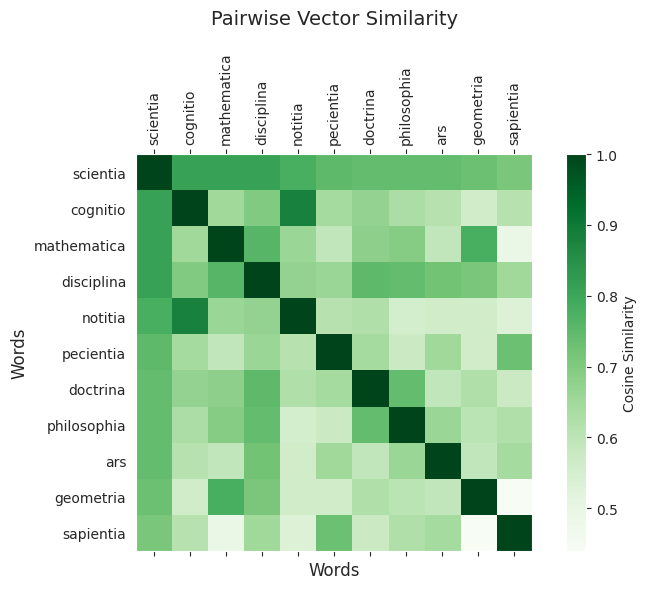

In [31]:
fig = plot_similarity_matrix(similarity_df, title="Pairwise Vector Similarity")

In [32]:
def get_tsne_coors(kv, perplexity=18):
    # inverse similarity to distance
    #data = (1 - sim_matrix) / 1
    words = np.array(kv.index_to_key)
    #data.round(5)
    # tSNE to project all words into a 2-dimensional space
    tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity, metric='cosine', max_iter=1000) # dissimilarity="precomputed",
    #tsne = TSNE(n_components=2, random_state=42, perplexity=18, metric='precomputed', n_iter=5000) # dissimilarity="precomputed",
    pos = tsne.fit_transform(kv.vectors) # project all points into space
    xs, ys = pos[:, 0], pos[:, 1]
    # extract minimal and maximal values
    minmax = [pos[:, 0].min(), pos[:, 0].max(), pos[:, 1].min(), pos[:, 1].max()]
    # normalize on scale from 0 to 1
    xs = (xs - minmax[0]) / (minmax[1] - minmax[0])
    ys = (ys - minmax[2]) / (minmax[3] - minmax[2])
    return xs, ys, words

In [33]:
%%time
# get coordinates for all vectors for all figures below...
coordinates_dict = {}
for key in vectors_dict.keys():
    xs, ys, words = get_tsne_coors(vectors_dict[key])
    coordinates_dict[key] = (xs, ys, words)

CPU times: user 24min 14s, sys: 1min 24s, total: 25min 39s
Wall time: 1min 48s


In [42]:
tsne_perplexities = {}
for perplexity in range(5,100, 10):
    tsne_perplexities[str(perplexity)] = get_tsne_coors(vectors_dict["NOSCEMUS - 1651-1700"], perplexity=perplexity)

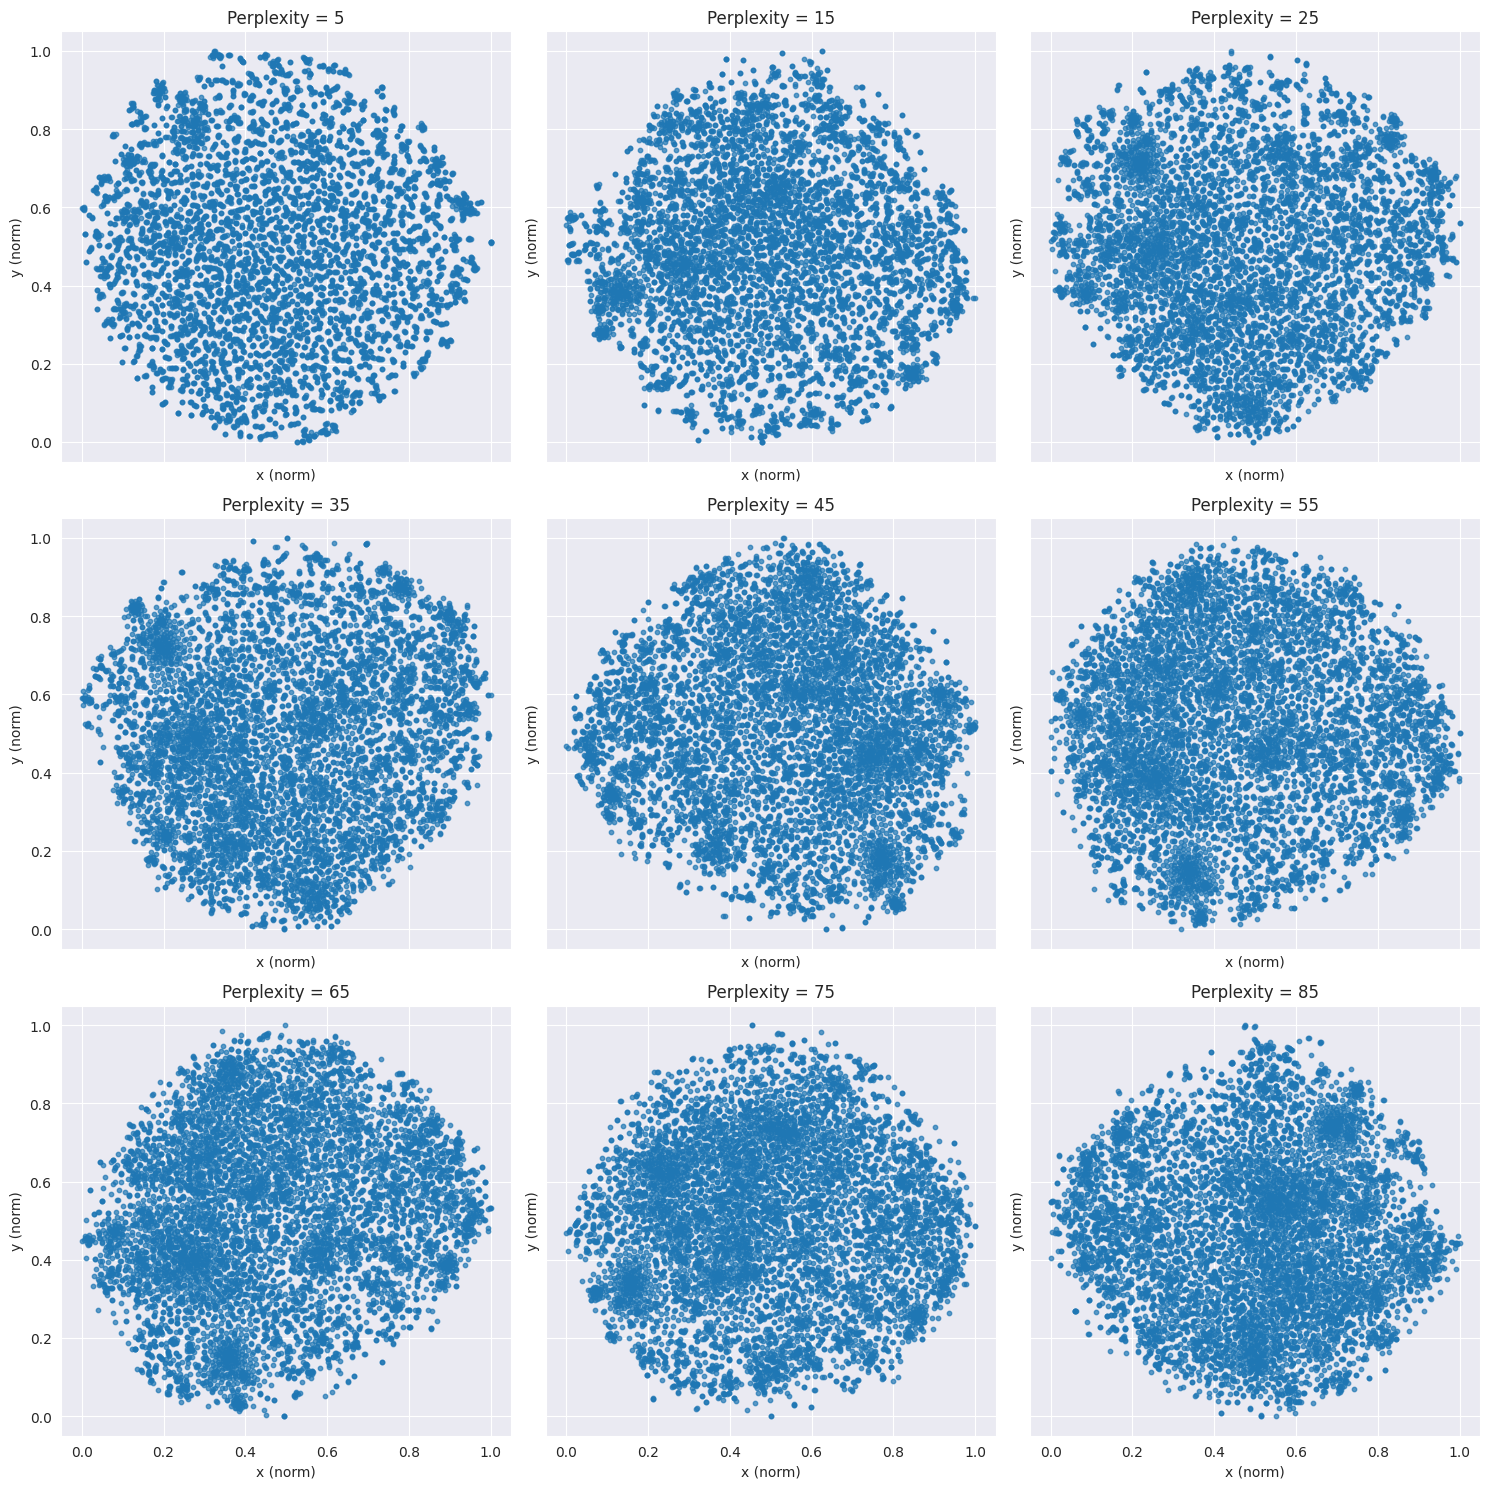

In [43]:
import matplotlib.pyplot as plt

# Use only the first 9 perplexities
perplexities = list(tsne_perplexities.keys())[:9]

fig, axes = plt.subplots(3, 3, figsize=(15, 15), sharex=True, sharey=True)
axes = axes.flatten()

for i, perplexity in enumerate(perplexities):
    xs, ys, _ = tsne_perplexities[perplexity]
    ax = axes[i]
    ax.scatter(xs, ys, s=10, alpha=0.7)
    ax.set_title(f"Perplexity = {perplexity}")
    ax.set_xlabel("x (norm)")
    ax.set_ylabel("y (norm)")
    ax.grid(True)

plt.tight_layout()
plt.show()


In [44]:
with open("../data/coordinates_dict.pkl", "wb") as file:
    pickle.dump(coordinates_dict, file)

In [45]:
with open("/srv/webserver/apps/iweems_app/data/coordinates_dict.pkl", "wb") as file:
    pickle.dump(coordinates_dict, file)

In [46]:
#with open("../data/coordinates_dict.pkl", "rb") as file:
#    coordinates_dict = pickle.load(file)

In [47]:
def get_tsne_coors_d3(kv, perplexity=18):
    words = np.array(kv.index_to_key)
    tsne = TSNE(n_components=3, random_state=42, perplexity=perplexity, metric='cosine', max_iter=1000) # dissimilarity="precomputed",
    pos = tsne.fit_transform(kv.vectors) # project all points into space
    xs, ys, zs = pos[:, 0], pos[:, 1], pos[:, 2]
    # extract minimal and maximal values
    minmax = [pos[:, 0].min(), pos[:, 0].max(), pos[:, 1].min(), pos[:, 1].max(), pos[:, 2].min(), pos[:, 2].max()]
    # normalize on scale from 0 to 1
    xs = (xs - minmax[0]) / (minmax[1] - minmax[0])
    ys = (ys - minmax[2]) / (minmax[3] - minmax[2])
    zs = (zs - minmax[4]) / (minmax[5] - minmax[4])
    return xs, ys, zs, words

In [48]:
%%time
# get coordinates for all vectors for all figures below...
coordinates3d_dict = {}
for key in vectors_dict.keys():
    xs, ys, zs, words = get_tsne_coors_d3(vectors_dict[key])
    coordinates3d_dict[key] = (xs, ys, zs, words)

CPU times: user 53min 26s, sys: 1min 22s, total: 54min 49s
Wall time: 3min 50s


In [49]:
with open("../data/coordinates3d_dict.pkl", "wb") as file:
    pickle.dump(coordinates3d_dict, file)

In [50]:
with open("/srv/webserver/apps/iweems_app/data/coordinates3d_dict.pkl", "wb") as file:
    pickle.dump(coordinates3d_dict, file)

In [29]:
#with open("../data/coordinates3d_dict.pkl", "rb") as file:
#    coordinates3d_dict = pickle.load(file)

In [52]:
# experiments with UMAP
import umap
import numpy as np

def get_umap_coors_d3(kv, n_neighbors=50, min_dist=0.3, metric='cosine'):
    words = np.array(kv.index_to_key)
    reducer = umap.UMAP(n_components=3, random_state=42, n_neighbors=n_neighbors, min_dist=min_dist, metric=metric)
    pos = reducer.fit_transform(kv.vectors)  # Project embeddings into 3D space
    xs, ys, zs = pos[:, 0], pos[:, 1], pos[:, 2]
    # Normalize coordinates between 0 and 1
    minmax = [pos[:, 0].min(), pos[:, 0].max(), pos[:, 1].min(), pos[:, 1].max(), pos[:, 2].min(), pos[:, 2].max()]
    xs = (xs - minmax[0]) / (minmax[1] - minmax[0])
    ys = (ys - minmax[2]) / (minmax[3] - minmax[2])
    zs = (zs - minmax[4]) / (minmax[5] - minmax[4])
    return xs, ys, zs, words

## Projections parametrization experiments

In [74]:
# tSNE perplexity grid
tsne_params = [
    {'perplexity': p}
    for p in [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 70, 80, 90, 100]
]

# UMAP parameter grid
umap_params = [
    {'n_neighbors': nn, 'min_dist': md}
    for nn in [10, 20, 50, 100, 200, 300]
    for md in [0.0, 0.1, 0.3, 0.5, 1.0]
]

In [75]:
def get_tsne_coors_d3(kv, perplexity=18):
    words = np.array(kv.index_to_key)
    tsne = TSNE(n_components=3, random_state=42, perplexity=perplexity, metric='cosine', max_iter=1000)
    pos = tsne.fit_transform(kv.vectors)
    minmax = [pos[:, 0].min(), pos[:, 0].max(), pos[:, 1].min(), pos[:, 1].max(), pos[:, 2].min(), pos[:, 2].max()]
    xs = (pos[:, 0] - minmax[0]) / (minmax[1] - minmax[0])
    ys = (pos[:, 1] - minmax[2]) / (minmax[3] - minmax[2])
    zs = (pos[:, 2] - minmax[4]) / (minmax[5] - minmax[4])
    return xs, ys, zs, words

def get_umap_coors_d3(kv, n_neighbors=50, min_dist=0.3, metric='cosine'):
    words = np.array(kv.index_to_key)
    reducer = umap.UMAP(n_components=3, random_state=42, n_neighbors=n_neighbors, min_dist=min_dist, metric=metric)
    pos = reducer.fit_transform(kv.vectors)
    minmax = [pos[:, 0].min(), pos[:, 0].max(), pos[:, 1].min(), pos[:, 1].max(), pos[:, 2].min(), pos[:, 2].max()]
    xs = (pos[:, 0] - minmax[0]) / (minmax[1] - minmax[0])
    ys = (pos[:, 1] - minmax[2]) / (minmax[3] - minmax[2])
    zs = (pos[:, 2] - minmax[4]) / (minmax[5] - minmax[4])
    return xs, ys, zs, words

In [76]:
results = []

# For reproducibility, pick a consistent value for n_neighbors in trustworthiness calculation
trust_n = 10  # or try 30, 50 for sensitivity

for param in tsne_params:
    xs, ys, zs, _ = get_tsne_coors_d3(vectors_dict["EMLAP"], **param)
    matrix_emlap = np.stack([xs, ys, zs], axis=1)
    tw_emlap = trustworthiness(vectors_dict["EMLAP"].vectors, matrix_emlap, n_neighbors=trust_n)

    xs, ys, zs, _ = get_tsne_coors_d3(vectors_dict["NOSCEMUS - Medicine"], **param)
    matrix_noscemus = np.stack([xs, ys, zs], axis=1)
    tw_noscemus = trustworthiness(vectors_dict["NOSCEMUS - Medicine"].vectors, matrix_noscemus, n_neighbors=trust_n)

    results.append({
        'method': 'tSNE',
        'params': f"perplexity={param['perplexity']}",
        'EMLAP': tw_emlap,
        'NOSCEMUS - Medicine': tw_noscemus
    })

In [77]:
for param in umap_params:
    xs, ys, zs, _ = get_umap_coors_d3(vectors_dict["EMLAP"], **param)
    matrix_emlap = np.stack([xs, ys, zs], axis=1)
    tw_emlap = trustworthiness(vectors_dict["EMLAP"].vectors, matrix_emlap, n_neighbors=trust_n)

    xs, ys, zs, _ = get_umap_coors_d3(vectors_dict["NOSCEMUS - Medicine"], **param)
    matrix_noscemus = np.stack([xs, ys, zs], axis=1)
    tw_noscemus = trustworthiness(vectors_dict["NOSCEMUS - Medicine"].vectors, matrix_noscemus, n_neighbors=trust_n)

    results.append({
        'method': 'UMAP',
        'params': f"n_neighbors={param['n_neighbors']}, min_dist={param['min_dist']}",
        'EMLAP': tw_emlap,
        'NOSCEMUS - Medicine': tw_noscemus
    })

/srv/venvs/latin_venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/srv/venvs/latin_venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/srv/venvs/latin_venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/srv/venvs/latin_venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/srv/venvs/latin_venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/srv/venvs/latin_venv/lib/py

In [80]:
df = pd.DataFrame(results)

In [81]:
df

,method,params,EMLAP,NOSCEMUS - Medicine
0,tSNE,perplexity=5,0.822777,0.877643
1,tSNE,perplexity=10,0.838884,0.885614
2,tSNE,perplexity=15,0.848894,0.888467
3,tSNE,perplexity=20,0.847227,0.890295
4,tSNE,perplexity=25,0.850024,0.894568
5,tSNE,perplexity=30,0.850681,0.892618
6,tSNE,perplexity=35,0.852017,0.893704
7,tSNE,perplexity=40,0.851354,0.893732
8,tSNE,perplexity=45,0.852951,0.892315
9,tSNE,perplexity=50,0.847464,0.890718


In [82]:
df.to_csv("../data/projections_experiment.csv")

## Final projections generation

In [53]:
%%time
# get coordinates for all vectors for all figures below...
coordinates3d_umap_dict = {}
for key in vectors_dict.keys():
    xs, ys, zs, words = get_umap_coors_d3(vectors_dict[key])
    coordinates3d_umap_dict[key] = (xs, ys, zs, words)

/srv/venvs/latin_venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/srv/venvs/latin_venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/srv/venvs/latin_venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/srv/venvs/latin_venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/srv/venvs/latin_venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/srv/venvs/latin_venv/lib/py

CPU times: user 3min 26s, sys: 1.16 s, total: 3min 27s
Wall time: 2min 43s


In [ ]:
filepaths = [
    "../data/coordinates3d_umap_dict.pkl"
    "/srv/webserver/apps/iweems_app/data/coordinates3d_umap_dict.pkl",
    "/home/jupyter-vojta/notebooks/iweems_huggingface/data/coordinates3d_umap_dict.pkl"
]
for filepath in filepaths:
    with open(filepath, "wb") as file:
        pickle.dump(coordinates3d_umap_dict, file)

In [84]:
%%time
# get coordinates for all vectors for all figures below...
coordinates3d_tsne_dict = {}
for key in vectors_dict.keys():
    xs, ys, zs, words = get_tsne_coors_d3(vectors_dict[key], perplexity=45)
    coordinates3d_tsne_dict[key] = (xs, ys, zs, words)

CPU times: user 58min 52s, sys: 1min 24s, total: 1h 17s
Wall time: 4min 18s


In [86]:
filepaths = [
    "../data/coordinates3d_tsne_dict.pkl",
    "/srv/webserver/apps/iweems_app/data/coordinates3d_tsne_dict.pkl",
    "/home/jupyter-vojta/notebooks/iweems_huggingface/data/coordinates3d_tsne_dict.pkl"
]
for filepath in filepaths:
    with open(filepath, "wb") as file:
        pickle.dump(coordinates3d_tsne_dict, file)

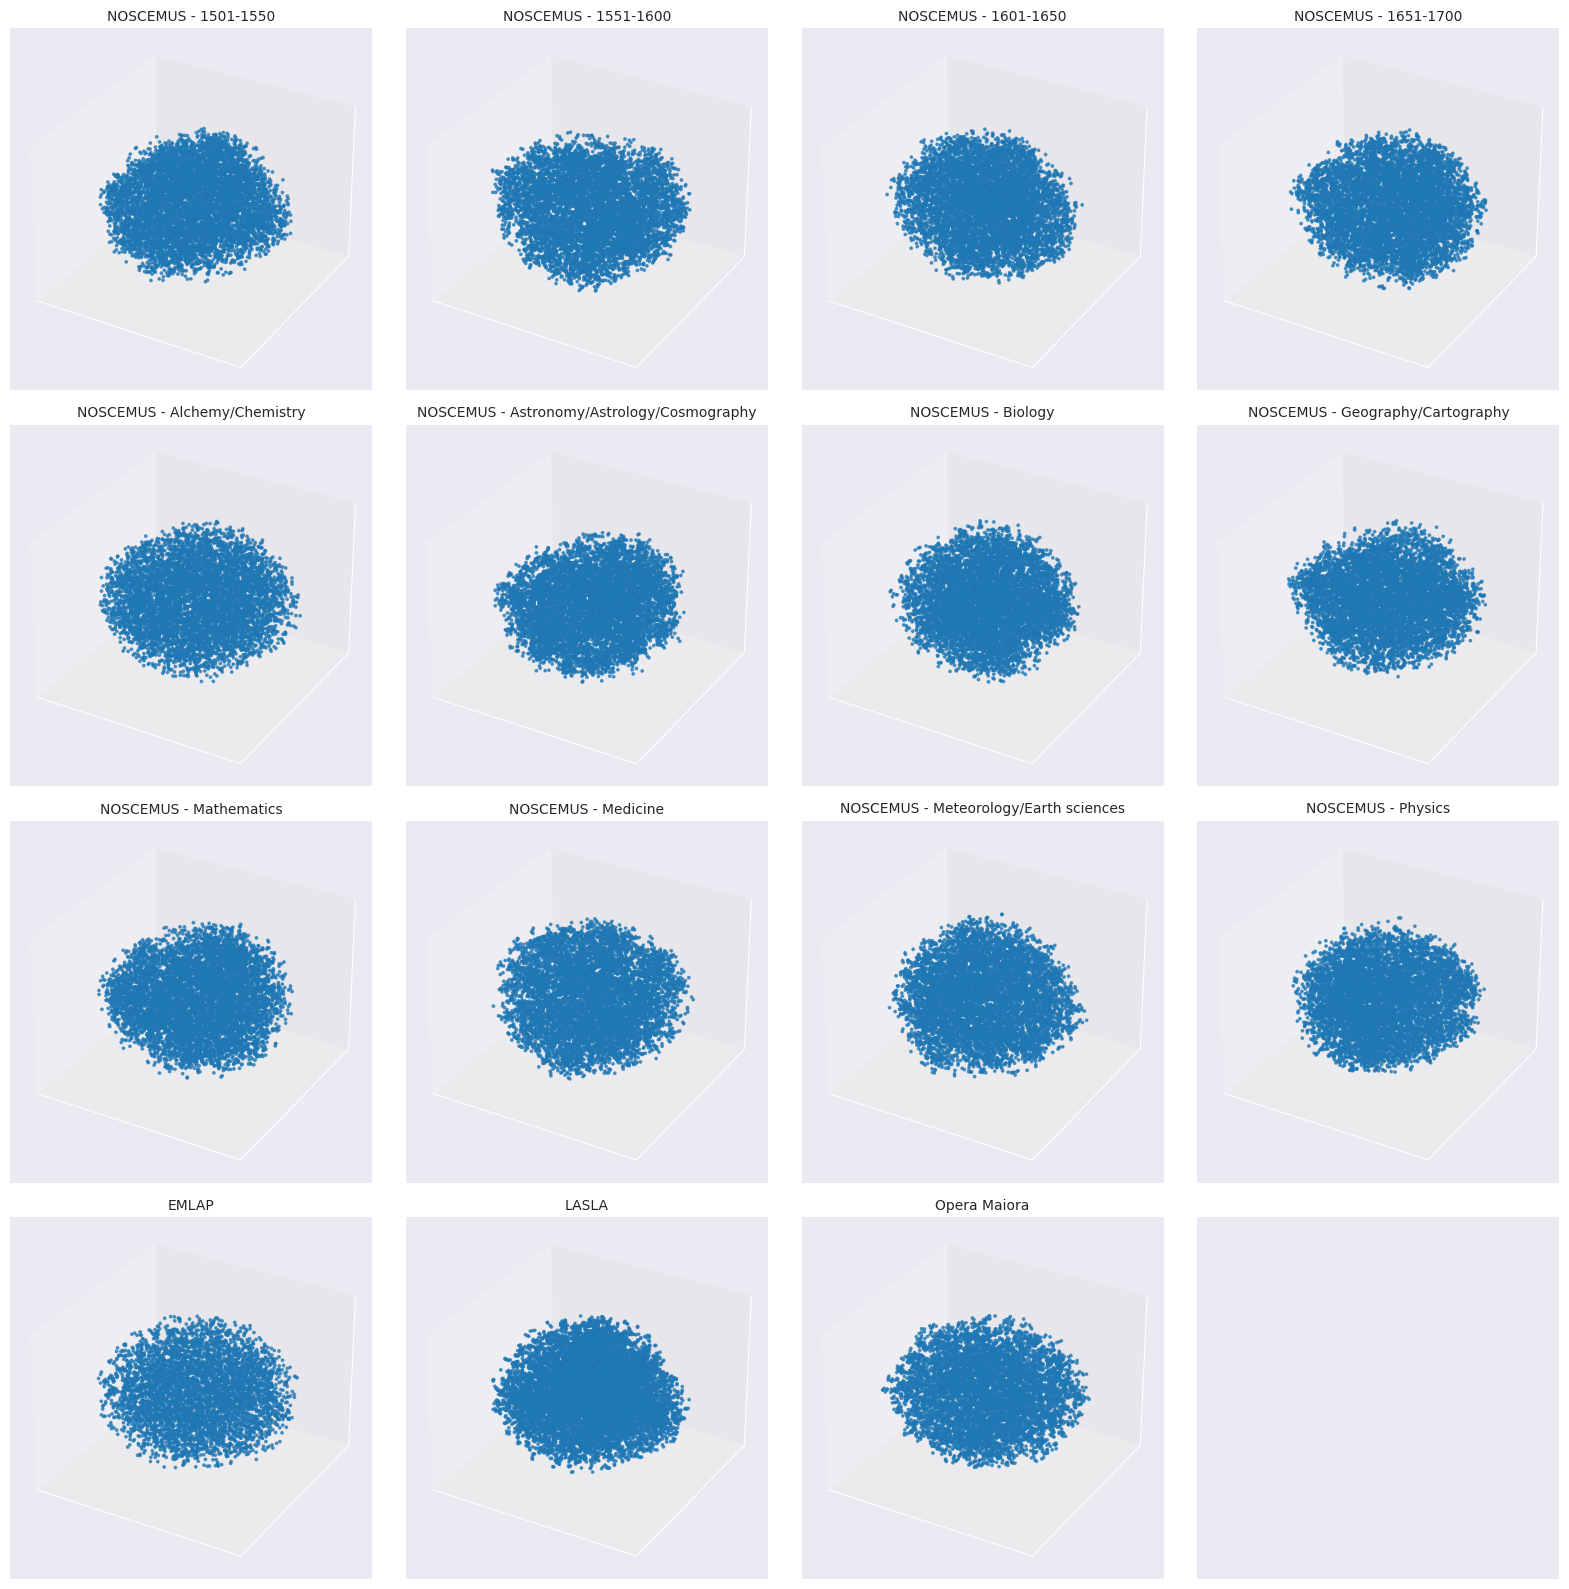

In [87]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401, needed for 3D projection

# List the keys to consistently order the subplots
subcorpus_keys = list(coordinates3d_tsne_dict.keys())

fig = plt.figure(figsize=(16, 16))
n_rows, n_cols = 4, 4

for idx, key in enumerate(subcorpus_keys):
    if idx >= n_rows * n_cols:
        break  # Only fill up to 16 plots
    xs, ys, zs, words = coordinates3d_tsne_dict[key]
    ax = fig.add_subplot(n_rows, n_cols, idx+1, projection='3d')
    ax.scatter(xs, ys, zs, s=3, alpha=0.7)
    ax.set_title(key, fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])

# Optionally, hide any leftover subplot(s)
for idx in range(len(subcorpus_keys), n_rows * n_cols):
    ax = fig.add_subplot(n_rows, n_cols, idx+1, projection='3d')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [88]:
fig.savefig("../figures/tsne_birdeye.png")

## Cross-corpora comparisons

In [104]:
filtered_vocab_df.columns

Index(['word', '1501-1550', '1551-1600', '1601-1650', '1651-1700', 'Medicine',
       'Astronomy/Astrology/Cosmography', 'Biology', 'Mathematics',
       'Meteorology/Earth sciences', 'Physics', 'Geography/Cartography',
       'Alchemy/Chemistry', 'EMLAP', 'mean', 'in_lila_embeddings', 'in_lasla',
       'in_operamaiora', '1501-1550_freq', '1551-1600_freq', '1601-1650_freq',
       '1651-1700_freq', 'Medicine_freq',
       'Astronomy/Astrology/Cosmography_freq', 'Biology_freq',
       'Mathematics_freq', 'Meteorology/Earth sciences_freq', 'Physics_freq',
       'Geography/Cartography_freq', 'Alchemy/Chemistry_freq', 'EMLAP_freq',
       'mean_freq', 'shared', 'transl'],
      dtype='object')

In [105]:
shared_words = filtered_vocab_df[(filtered_vocab_df["shared"]) & (filtered_vocab_df["in_lila_embeddings"])]["word"].tolist()

In [109]:
len(shared_words)

3061

In [106]:
target = "mercurius"
#vectors_dict["NOSCEMUS - 1501-1550"][target]
## Additional explorations

array([ 3.92335355e-01, -3.61561507e-01,  4.95302051e-01,  1.74979955e-01,
        3.30491066e-02, -2.87193060e-01, -1.10610463e-01, -3.66514266e-01,
        1.14592262e-01,  3.58986884e-01,  4.36047204e-02, -1.98843792e-01,
        1.57204583e-01,  1.55365601e-01, -2.21378990e-02,  9.28663835e-02,
        2.52081424e-01, -1.10565245e-01,  1.94712784e-02,  1.58810854e-01,
        3.72456044e-01,  3.31779003e-01,  7.98711926e-02,  3.33129615e-01,
       -1.82637140e-01,  2.21124180e-02, -9.41792578e-02, -4.88221020e-01,
        3.82790118e-01, -7.67588317e-01,  4.52633858e-01,  1.95304304e-01,
        2.89027281e-02, -1.43923080e-02, -9.11025852e-02,  2.82586634e-01,
        1.56000471e-02,  2.40475684e-01,  5.94109297e-04,  1.35834605e-01,
       -4.76427853e-01,  8.82964730e-01,  1.72364280e-01, -1.89050764e-01,
       -4.45854589e-02,  1.65486321e-01, -2.56398022e-01, -4.17059630e-01,
       -7.88805366e-01,  1.26741737e-01, -1.61908224e-01,  1.33488607e-02,
       -1.40973493e-01,  

In [103]:
vectors_dict.keys()

dict_keys(['NOSCEMUS - 1501-1550', 'NOSCEMUS - 1551-1600', 'NOSCEMUS - 1601-1650', 'NOSCEMUS - 1651-1700', 'NOSCEMUS - Alchemy/Chemistry', 'NOSCEMUS - Astronomy/Astrology/Cosmography', 'NOSCEMUS - Biology', 'NOSCEMUS - Geography/Cartography', 'NOSCEMUS - Mathematics', 'NOSCEMUS - Medicine', 'NOSCEMUS - Meteorology/Earth sciences', 'NOSCEMUS - Physics', 'EMLAP', 'LASLA', 'Opera Maiora'])

In [ ]:
target = "mercurius"

sim_scores_subcorpora = [vectors_dict[key].distances(target, shared_words) for key in vectors_dict.keys()]

In [115]:
sim_scores_subcorpora

[array([0.5799228, 0.7592528, 0.6582052, ..., 0.7318506, 0.8678702,
        0.7241453], dtype=float32),
 array([0.6037402 , 0.73524034, 0.67287445, ..., 0.7143342 , 0.91014004,
        0.78142166], dtype=float32),
 array([0.61867094, 0.7371486 , 0.7091265 , ..., 0.80448145, 0.8735351 ,
        0.86377907], dtype=float32),
 array([0.645928  , 0.72046685, 0.66100526, ..., 0.93565065, 0.9020326 ,
        0.805472  ], dtype=float32),
 array([0.3449747 , 0.8357456 , 0.532902  , ..., 0.74701476, 1.0015955 ,
        0.76514274], dtype=float32),
 array([0.6475668 , 0.75308913, 0.7179661 , ..., 0.8260515 , 0.9375026 ,
        0.8128561 ], dtype=float32),
 array([0.49388927, 0.6978398 , 0.60347044, ..., 0.90694255, 0.77316785,
        0.73549664], dtype=float32),
 array([0.6184406 , 0.7128624 , 0.6881056 , ..., 0.7743911 , 0.85910577,
        0.74491334], dtype=float32),
 array([0.6090953 , 0.734673  , 0.75064886, ..., 0.93982327, 0.8832258 ,
        0.93921506], dtype=float32),
 array([0.581478

In [117]:

# keys: subcorpus labels
subcorpus_labels = list(vectors_dict.keys())

# Convert list of arrays (or lists) to a DataFrame: rows=subcorpora, columns=shared_words
sim_scores_df = pd.DataFrame(sim_scores_subcorpora, index=subcorpus_labels, columns=shared_words)

# Correlation between all subcorpora
sim_matrix = sim_scores_df.T.corr(method='pearson')  # or 'spearman'

# Put into DataFrame for labeling
sim_matrix_df = pd.DataFrame(sim_matrix, index=subcorpus_labels, columns=subcorpus_labels)

In [118]:
sim_matrix_df

,NOSCEMUS - 1501-1550,NOSCEMUS - 1551-1600,NOSCEMUS - 1601-1650,NOSCEMUS - 1651-1700,NOSCEMUS - Alchemy/Chemistry,NOSCEMUS - Astronomy/Astrology/Cosmography,NOSCEMUS - Biology,NOSCEMUS - Geography/Cartography,NOSCEMUS - Mathematics,NOSCEMUS - Medicine,NOSCEMUS - Meteorology/Earth sciences,NOSCEMUS - Physics,EMLAP,LASLA,Opera Maiora
NOSCEMUS - 1501-1550,1.000000,0.560559,0.462592,0.446689,0.200228,0.646111,0.322895,0.353615,0.368972,0.415626,0.345654,0.379130,0.211175,0.155224,-0.002071
NOSCEMUS - 1551-1600,0.560559,1.000000,0.578040,0.572842,0.464915,0.577721,0.613683,0.547585,0.421015,0.697857,0.608734,0.468962,0.434859,0.270991,0.105591
NOSCEMUS - 1601-1650,0.462592,0.578040,1.000000,0.570302,0.451928,0.572795,0.509873,0.471227,0.429070,0.565480,0.533277,0.495390,0.356258,0.209304,0.070991
NOSCEMUS - 1651-1700,0.446689,0.572842,0.570302,1.000000,0.443425,0.609626,0.541360,0.544790,0.556705,0.532315,0.591522,0.650139,0.371425,0.231030,0.031890
NOSCEMUS - Alchemy/Chemistry,0.200228,0.464915,0.451928,0.443425,1.000000,0.315860,0.502576,0.482253,0.370817,0.426360,0.576711,0.348446,0.629825,0.168938,0.002353
NOSCEMUS - Astronomy/Astrology/Cosmography,0.646111,0.577721,0.572795,0.609626,0.315860,1.000000,0.322132,0.549553,0.571746,0.419646,0.482770,0.512936,0.327287,0.264345,0.006391
NOSCEMUS - Biology,0.322895,0.613683,0.509873,0.541360,0.502576,0.322132,1.000000,0.523870,0.275698,0.633648,0.653381,0.406374,0.403062,0.212206,0.062793
NOSCEMUS - Geography/Cartography,0.353615,0.547585,0.471227,0.544790,0.482253,0.549553,0.523870,1.000000,0.546360,0.469071,0.669791,0.451834,0.462076,0.375537,0.082921
NOSCEMUS - Mathematics,0.368972,0.421015,0.429070,0.556705,0.370817,0.571746,0.275698,0.546360,1.000000,0.353504,0.494598,0.580743,0.332747,0.296455,0.056211
NOSCEMUS - Medicine,0.415626,0.697857,0.565480,0.532315,0.426360,0.419646,0.633648,0.469071,0.353504,1.000000,0.572801,0.462460,0.334070,0.274059,0.126367


In [128]:
def target_crosscorpora_matrix(target):
        sim_scores_subcorpora = [vectors_dict[key].distances(target, shared_words) for key in vectors_dict.keys()]
        subcorpus_labels = list(vectors_dict.keys())
        # Convert list of arrays (or lists) to a DataFrame: rows=subcorpora, columns=shared_words
        sim_scores_df = pd.DataFrame(sim_scores_subcorpora, index=subcorpus_labels, columns=shared_words)
        # Correlation between all subcorpora
        sim_matrix = sim_scores_df.T.corr(method='pearson')  # or 'spearman'
        # Put into DataFrame for labeling
        sim_matrix_df = pd.DataFrame(sim_matrix, index=subcorpus_labels, columns=subcorpus_labels)
        title = f"Correlation between {target} Usage Profile Across Subcorpora"
        fig, ax = plt.subplots(figsize=(10, 10))
        cax = ax.matshow(sim_matrix_df, cmap='Greens')
        fig.colorbar(cax, label='Correlation')
        ax.set_title(title, fontsize=14, pad=20)
        ax.set_xlabel("Subcorpora", fontsize=12)
        ax.set_ylabel("Subcorpora", fontsize=12)
        ticks = np.arange(len(sim_matrix_df.columns))
        ax.set_xticks(ticks)
        ax.set_xticklabels(sim_matrix_df.columns, rotation=90, fontsize=10)
        ax.set_yticks(ticks)
        ax.set_yticklabels(sim_matrix_df.index, fontsize=10)
        ax.grid(False)
        plt.tight_layout()
        return fig

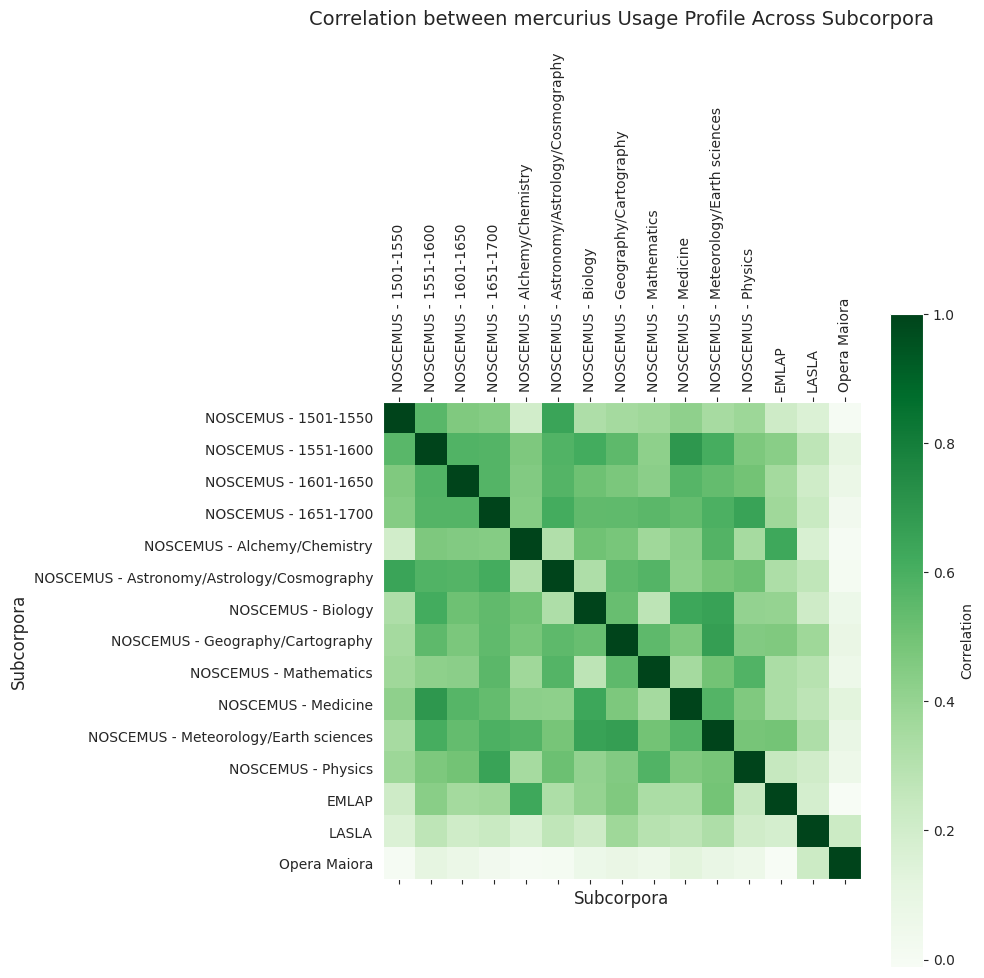

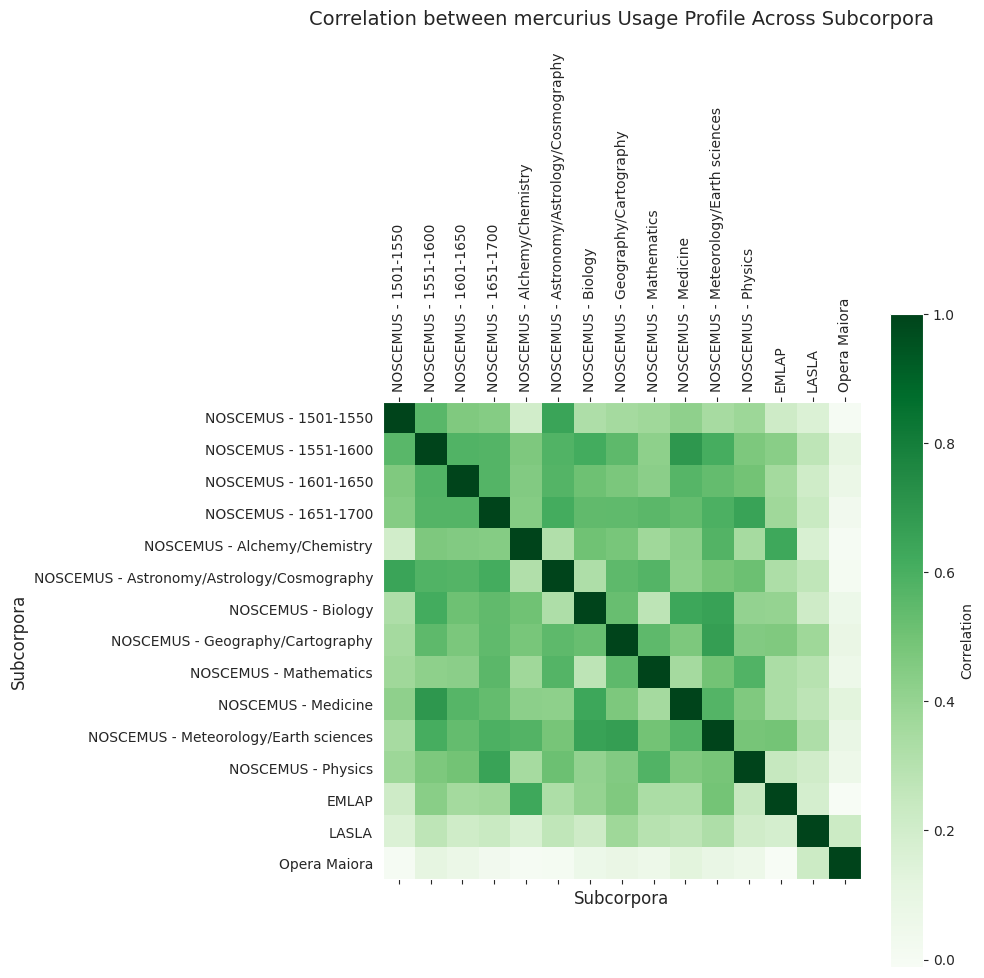

In [129]:
target_crosscorpora_matrix("mercurius")

In [ ]:
target = "scientia"
i = np.where(words == target) # find the positional index
x, y, z = xs[i], ys[i], zs[i] # apply the positional index to navigate through xs and ys
print(x, y, z)

In [ ]:
wordlist = [tup[0] for tup in vectors_dict["1651-1700"].most_similar("scientia", topn=100)]

# TO-DO: save and load to test plotly

In [ ]:
with open("../data/wordlist.json", "w") as file:
    json.dump(wordlist, file)

In [ ]:
def rand_col(seed=0):
    np.random.seed(seed=seed)
    color = np.random.randint(0, 180, size=3)
    color = np.round(color / 256, 2)
    return tuple(color)

In [ ]:
def draw_special_words(ax, wordlist, color="random_color", rotation=True, fontsize=10):
    idx = [word[0] for word in enumerate(words) if word[1] in wordlist]
    if isinstance(color, dict):
        colors_dict = color
    elif color=="random_color":
        colors_dict = dict([(w, rand_col(seed=n)) for n, w in enumerate(wordlist)])
    else:
        colors_dict = dict([(w, color) for w in wordlist])
    if rotation:
        rotations = [np.random.randint(0,360) for w in wordlist]
    else:
        rotations = [0 for w in wordlist]
    for x,y,w,r in zip(xs[idx], ys[idx] - 0.003, words[idx], rotations):
        ax.text(x,y,w, horizontalalignment='center', verticalalignment='center', fontsize=fontsize, color=colors_dict[w], zorder=3, rotation=r)

In [ ]:
!mkdir ../figures/large_embeddings/

In [ ]:
%%capture
for key in vectors_dict.keys():
    kv = vectors_dict[key]
    xs, ys, words = get_tsne_coors(kv, perplexity=10)
    fig, ax = plt.subplots(1, 1, figsize=(24, 24), dpi=300, tight_layout=True)
    #ax.scatter(xs, ys, s=1, color="lightgrey", zorder=1)
    
    draw_special_words(ax=ax, wordlist=words, color="random_color", fontsize=8)
    
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    
    ax.set_xlim(-0.02,1.02)
    ax.set_ylim(-0.02,1.02)
    fig.savefig("../figures/large_embeddings/embeddings_{}.png".format(key))

In [ ]:
kv = vectors_dict["1651-1700"]
xs, ys, words = get_tsne_coors(kv, perplexity=10)

In [ ]:
special_words = [tup[0] for tup in vectors_dict["1651-1700"].most_similar("scientia", topn=20)]
special_words

In [ ]:
#vectors_dict["lasla"] = lasla
#vectors_dict["operamaiora"] = operamaiora

In [ ]:
['lasla', '1501-1550', '1551-1600', 'operamaiora', '1601-1650', '1651-1700']

In [ ]:
%%time
# use carefully! - takes time to execute
positions_dict = {}
for key in vectors_dict.keys():
    kv = vectors_dict[key]
    positions_dict[key] = get_tsne_coors(kv, perplexity=8)

In [ ]:
fig, axs = plt.subplots(2,3, figsize=(9, 6), dpi=300, tight_layout=True)

colors_dict = dict([(w, rand_col(seed=n)) for n, w in enumerate(special_words)])

for ax,key in zip(axs.ravel(), ['lasla', '1501-1550', '1551-1600', 'operamaiora', '1601-1650', '1651-1700']):
    kv = vectors_dict[key]
    xs, ys, words = positions_dict[key]
    ax.scatter(xs, ys, s=1, color="lightgrey", zorder=1)
    special_words_filtered = [w for w in special_words if w in words]
    draw_special_words(ax=ax, wordlist=special_words_filtered, rotation=True, color=colors_dict, fontsize=10)
    ax.set_xlim(-0.1,1.1)
    ax.set_ylim(-0.02,1.05)

    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    if key == "lasla":
        title = "LASLA (classical authors)" 
    elif key == "operamaiora":
        title = "Opera Maiora (Aquinas)"
    else:
        title = "Noscemus {}".format(key) 
    ax.set_title(title, fontsize=8, pad=-12)

In [ ]:
fig.savefig("../figures/embeddings_scientia.png")

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
vectors_dict["lasla"].vectors

In [ ]:
kmeans = KMeans(n_clusters=10, random_state=0, n_init="auto").fit_predict(X=vectors_dict["lasla"].vectors)

In [ ]:
clusters_colors_dict = dict([(i, rand_col(seed=i+0)) for i in range(10)])
words_clustercolors_dict = dict([(w, clusters_colors_dict[clust]) for w, clust in zip(vectors_dict["lasla"].index_to_key, kmeans)])

In [ ]:
fig, axs = plt.subplots(2,3, figsize=(9, 6), dpi=600, tight_layout=True)

for ax,key in zip(axs.ravel(), ['lasla', '1501-1550', '1551-1600', 'operamaiora', '1601-1650', '1651-1700']):
    kv = vectors_dict[key]
    xs, ys, words = positions_dict[key]
    colors_list=[]
    for w in words:
        try:
            colors_list.append(words_clustercolors_dict[w])
        except:
            colors_list.append("black")
    ax.scatter(xs, ys, s=1, color=colors_list, zorder=1)
    special_words_filtered = [w for w in special_words if w in words]
    #draw_special_words(ax=ax, wordlist=special_words_filtered, rotation=True, color=colors_dict)
    ax.set_xlim(-0.1,1.1)
    ax.set_ylim(-0.02,1.05)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    if key == "lasla":
        title = "LASLA (classical authors)"
    elif key == "operamaiora":
        title = "Opera Maiora (Aquinas)"
    else:
        title = "Noscemus {}".format(key)
    ax.set_title(title, fontsize=8, pad=-12)

In [ ]:
fig.savefig("../figures/6embeddings_clustercolors_dots.png")

In [ ]:
fig, axs = plt.subplots(2,3, figsize=(9, 6), dpi=300, tight_layout=True)

wordcolor_tups = []
for w in special_words:
    try:
        wordcolor_tups.append((w, words_clustercolors_dict[w]))
    except:
        wordcolor_tups.append((w, "black"))
colors_dict = dict(wordcolor_tups)

for ax,key in zip(axs.ravel(), ['lasla', '1501-1550', '1551-1600', 'operamaiora', '1601-1650', '1651-1700']):
    kv = vectors_dict[key]
    xs, ys, words = positions_dict[key]
    ax.scatter(xs, ys, s=1, color="lightgrey", zorder=1)
    special_words_filtered = [w for w in special_words if w in words]
    draw_special_words(ax=ax, wordlist=special_words_filtered, rotation=True, color=colors_dict, fontsize=8)
    ax.set_xlim(-0.1,1.1)
    ax.set_ylim(-0.02,1.05)

    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    if key == "lasla":
        title = "LASLA (classical authors)"
    elif key == "operamaiora":
        title = "Opera Maiora (Aquinas)"
    else:
        title = "Noscemus {}".format(key)
    ax.set_title(title, fontsize=8, pad=-12)

In [ ]:
fig.savefig("../figures/6embeddings_clustercolors_scientia.png")

In [ ]:
%%capture
for key in vectors_dict.keys():
    kv = vectors_dict[key]
    xs, ys, words = positions_dict[key]
    fig, ax = plt.subplots(1, 1, figsize=(24, 24), dpi=300, tight_layout=True)
    #ax.scatter(xs, ys, s=1, color="lightgrey", zorder=1)

    draw_special_words(ax=ax, wordlist=words, color="random_color", fontsize=5)

    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    ax.set_xlim(-0.02,1.02)
    ax.set_ylim(-0.02,1.02)
    fig.savefig("../figures/large_embeddings/embeddings_{}.png".format(key))